In [1]:
from utils.utils import *
import numpy as np

In [2]:
df = spark.read.csv('../data/rating.csv', header=True)
movie = spark.read.csv('../data/movie.csv', header=True)

In [3]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [4]:
df.show(5, truncate=False)

+------+-------+------+-------------------+
|userId|movieId|rating|timestamp          |
+------+-------+------+-------------------+
|1     |2      |3.5   |2005-04-02 23:53:47|
|1     |29     |3.5   |2005-04-02 23:31:16|
|1     |32     |3.5   |2005-04-02 23:33:39|
|1     |47     |3.5   |2005-04-02 23:32:07|
|1     |50     |3.5   |2005-04-02 23:29:40|
+------+-------+------+-------------------+
only showing top 5 rows


In [5]:
movie.show(5, truncate=False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows


In [6]:
df.rdd.getNumPartitions()

22

In [8]:
agg_user = df.groupBy('userId').count().toPandas()

In [9]:
df.select('userId').distinct().count()

138493

In [10]:
df.count()

20000263

In [11]:
df.select('movieId').distinct().count()

26744

In [12]:
movie.count()

27278

In [13]:
20000263/138493

144.4135299257002

In [14]:
df.groupby('userId').count()

DataFrame[userId: string, count: bigint]

In [17]:
!pip install matplotlib

     ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
     ---------------------------------------- 0.1/8.1 MB 2.6 MB/s eta 0:00:04
     - -------------------------------------- 0.2/8.1 MB 2.9 MB/s eta 0:00:03
     - -------------------------------------- 0.3/8.1 MB 2.6 MB/s eta 0:00:04
     - -------------------------------------- 0.3/8.1 MB 2.6 MB/s eta 0:00:04
     - -------------------------------------- 0.3/8.1 MB 2.6 MB/s eta 0:00:04
     - -------------------------------------- 0.3/8.1 MB 980.4 kB/s eta 0:00:08
     - -------------------------------------- 0.3/8.1 MB 981.5 kB/s eta 0:00:08
     - -------------------------------------- 0.3/8.1 MB 981.5 kB/s eta 0:00:08
     - -------------------------------------- 0.3/8.1 MB 981.5 kB/s eta 0:00:08
     - -------------------------------------- 0.4/8.1 MB 791.2 kB/s eta 0:00:10
     - -------------------------------------- 0.4/8.1 MB 791.2 kB/s eta 0:00:10
     --- ------------------------------------ 0.7/8.1 MB 1.


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


<Axes: >

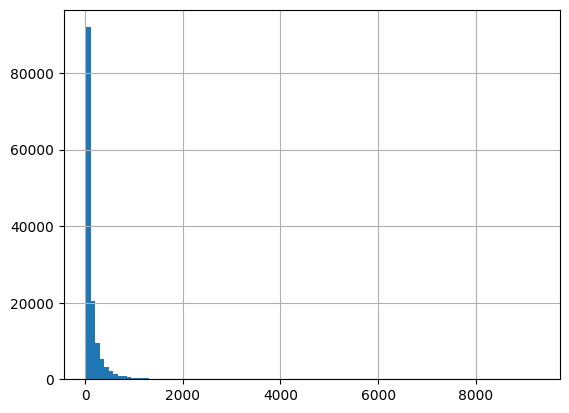

In [18]:
agg_user['count'].hist(bins=100)

In [19]:
agg_user.head()

,userId,count
0,296,25
1,467,30
2,675,187
3,691,35
4,829,387


In [20]:
percentiles = [a/100 for a in range(100)]
agg = df.groupby('userId').count().agg(
    F.min(F.col('count')).alias('min'),
    F.percentile_approx(F.col('count'), percentiles, 10000).alias('percentiles'),
    F.max(F.col('count')).alias('max'),
    F.avg(F.col('count')).alias('avg')
).toPandas()

In [21]:
agg['percentiles'][0][49]

66

In [22]:
agg

,min,percentiles,max,avg
0,20,"[20, 20, 20, 20, 21, 21, 22, 22, 23, 23, 24, 2...",9254,144.41353


In [23]:
print(agg['percentiles'].tolist())

[[20, 20, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 26, 26, 27, 28, 28, 29, 30, 30, 31, 32, 33, 34, 35, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 48, 49, 50, 51, 53, 54, 56, 57, 59, 60, 62, 64, 66, 68, 70, 72, 74, 76, 79, 81, 84, 87, 90, 92, 96, 99, 102, 104, 108, 111, 115, 119, 123, 127, 132, 137, 143, 149, 155, 161, 168, 175, 184, 193, 202, 211, 221, 233, 246, 260, 276, 295, 312, 334, 360, 390, 424, 467, 520, 586, 683, 833, 1112]]


In [24]:
# DAG - directed acyclic graph
# transformation chain
# cache

In [25]:
t1 = df.groupby('userId').count()

In [26]:
t2 = t1.agg(
    F.min(F.col('count')).alias('min'),
    F.percentile_approx(F.col('count'), percentiles, 10000).alias('percentiles'),
    F.max(F.col('count')).alias('max'),
    F.avg(F.col('count')).alias('avg')
)

In [27]:
t1.count()

138493

In [28]:
t2.count()

1

In [29]:
t1.count()

138493

In [30]:
t1_cache = t1.cache()

In [31]:
t1_cache.count()

138493

In [32]:
t1_cache.count()

138493

In [33]:
t1_cache.agg(
    F.min(F.col('count')).alias('min'),
    F.percentile_approx(F.col('count'), percentiles, 10000).alias('percentiles'),
    F.max(F.col('count')).alias('max'),
    F.avg(F.col('count')).alias('avg')
).count()

1

In [34]:
t1.persist()

DataFrame[userId: string, count: bigint]

In [35]:
# task
# - to visualize and present the results of percentile from the lecture to make statement that the data is biased, support the idea of choosing median over mean
# - find the top 5 most active users, most rated, highly rated movies
# - find "popular" movies (define the criteria)
# - find users genres that are most highly rated
# - find users that rate most often each month
#
# visualize results when necessary

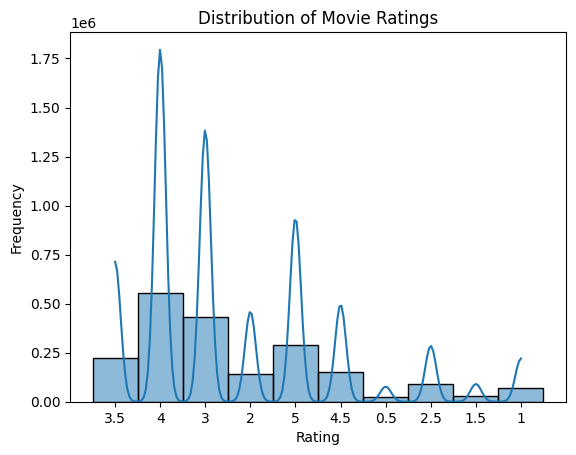

In [38]:
ratings = df.select("rating").sample(fraction=0.1).toPandas()
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(ratings["rating"], bins=10, kde=True)
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [39]:
top_users = (
    df.groupBy("userId")
      .agg(F.count("rating").alias("num_ratings"))
      .orderBy(F.desc("num_ratings"))
      .limit(5)
)
top_users.show()

+------+-----------+
|userId|num_ratings|
+------+-----------+
|118205|       9254|
|  8405|       7515|
| 82418|       5646|
|121535|       5520|
|125794|       5491|
+------+-----------+



In [40]:
highly_rated_movies = (
    df.groupBy("movieId")
      .agg(
          F.avg("rating").alias("avg_rating"),
          F.count("rating").alias("num_ratings")
      )
      .filter(F.col("num_ratings") >= 50)
      .join(movie, "movieId")
      .orderBy(F.desc("avg_rating"))
      .limit(5)
)
highly_rated_movies.show(truncate=False)

+-------+-----------------+-----------+--------------------------------+----------------------+
|movieId|avg_rating       |num_ratings|title                           |genres                |
+-------+-----------------+-----------+--------------------------------+----------------------+
|318    |4.446990499637029|63366      |Shawshank Redemption, The (1994)|Crime|Drama           |
|858    |4.364732196832306|41355      |Godfather, The (1972)           |Crime|Drama           |
|50     |4.334372207803259|47006      |Usual Suspects, The (1995)      |Crime|Mystery|Thriller|
|527    |4.310175010988133|50054      |Schindler's List (1993)         |Drama|War             |
|1221   |4.275640557704942|27398      |Godfather: Part II, The (1974)  |Crime|Drama           |
+-------+-----------------+-----------+--------------------------------+----------------------+



In [41]:
popular_movies = (
    df.groupBy("movieId")
      .agg(
          F.avg("rating").alias("avg_rating"),
          F.count("rating").alias("num_ratings")
      )
      .filter((F.col("avg_rating") >= 4.0) & (F.col("num_ratings") >= 100))
      .join(movie, "movieId")
      .orderBy(F.desc("num_ratings"))
)
popular_movies.show(10, truncate=False)

+-------+-----------------+-----------+-------------------------------------------------+---------------------------+
|movieId|avg_rating       |num_ratings|title                                            |genres                     |
+-------+-----------------+-----------+-------------------------------------------------+---------------------------+
|296    |4.174231169217055|67310      |Pulp Fiction (1994)                              |Comedy|Crime|Drama|Thriller|
|356    |4.029000181345584|66172      |Forrest Gump (1994)                              |Comedy|Drama|Romance|War   |
|318    |4.446990499637029|63366      |Shawshank Redemption, The (1994)                 |Crime|Drama                |
|593    |4.17705650958151 |63299      |Silence of the Lambs, The (1991)                 |Crime|Horror|Thriller      |
|260    |4.190671901948552|54502      |Star Wars: Episode IV - A New Hope (1977)        |Action|Adventure|Sci-Fi    |
|110    |4.042533802004873|53769      |Braveheart (1995)

In [42]:
df_genres = df.join(movie, "movieId")

user_genre_ratings = (
    df_genres.groupBy("userId", "genres")
             .agg(F.avg("rating").alias("avg_rating"))
)

windowSpec = Window.partitionBy("userId").orderBy(F.desc("avg_rating"))

top_genre_per_user = (
    user_genre_ratings.withColumn("rank", F.rank().over(windowSpec))
                      .filter(F.col("rank") == 1)
)
top_genre_per_user.show(truncate=False)

+------+----------------------------------------+----------+----+
|userId|genres                                  |avg_rating|rank|
+------+----------------------------------------+----------+----+
|100010|Comedy|Fantasy|Romance                  |5.0       |1   |
|100010|Horror                                  |5.0       |1   |
|100010|Adventure|Film-Noir|Sci-Fi|Thriller     |5.0       |1   |
|100010|Children|Drama|Fantasy                  |5.0       |1   |
|100010|Western                                 |5.0       |1   |
|100010|Crime|Drama|Thriller                    |5.0       |1   |
|100010|Action|Comedy|Sci-Fi                    |5.0       |1   |
|100010|Animation|Children|Fantasy|Musical      |5.0       |1   |
|100010|Drama|Horror                            |5.0       |1   |
|100010|Mystery|Thriller                        |5.0       |1   |
|100090|Comedy|Crime                            |5.0       |1   |
|100129|Crime|Drama                             |5.0       |1   |
|100129|Cr

In [46]:
df = df.withColumn("date", F.to_timestamp("timestamp", "yyyy-MM-dd HH:mm:ss"))
df = df.withColumn("month", F.date_format(F.col("date"), "yyyy-MM"))

In [47]:
user_month_counts = (
    df.groupBy("userId", "month")
      .agg(F.count("rating").alias("rating_count"))
)
windowSpec = Window.partitionBy("month").orderBy(F.desc("rating_count"))

top_user_per_month = (
    user_month_counts.withColumn("rank", F.rank().over(windowSpec))
                     .filter(F.col("rank") == 1)
)
top_user_per_month.show(truncate=False)

+------+-------+------------+----+
|userId|month  |rating_count|rank|
+------+-------+------------+----+
|131160|1995-01|3           |1   |
|85252 |1996-01|18          |1   |
|124035|1996-02|64          |1   |
|45989 |1996-03|122         |1   |
|12126 |1996-04|200         |1   |
|19067 |1996-05|605         |1   |
|46663 |1996-06|661         |1   |
|125912|1996-07|386         |1   |
|41389 |1996-08|594         |1   |
|107732|1996-09|657         |1   |
|81596 |1996-10|442         |1   |
|1931  |1996-11|722         |1   |
|4989  |1996-12|475         |1   |
|61432 |1997-01|512         |1   |
|128653|1997-02|728         |1   |
|5814  |1997-03|849         |1   |
|124052|1997-04|752         |1   |
|124052|1997-05|600         |1   |
|8962  |1997-06|498         |1   |
|101971|1997-07|559         |1   |
+------+-------+------------+----+
only showing top 20 rows
